# Task 1. 
Moby Dick is an extremely long novel, and the size of the plain-text file containing the unabridged version is approximately 1.2 MB. (see https://gutenberg.org/ebooks/2701). However, language is relatively easy to compress, as it is very redundant.
- Encode the novel with Huffman and Shannon-Fano compression, using individual characters as symbols and estimating their probability by their relative frequency You can use any programming language to implement both the codes and the probability estimation.

In [1]:
# Import the text in the Moby dick.txt file and count the number of each character in the text.

from collections import Counter
import matplotlib.pyplot as plt
import heapq
from graphviz import Digraph
import os
import re

## Huffman coding algorithm
The Huffman coding algorithm is implemented by building the Huffman tree in reverse. This means computing the symbol frequency and mapping the most infrequent symbols first. The frequency of these symbols is then merged into an internal node, this process is repeated until the root of the tree is reached.

In [2]:
class huffman_node:
    '''
    Container class for each node in the huffman tree
    
    Attributes:
        symbol: The character or symbol which is encoded in this node
        frequency: The frequency of the symbol
        left: The left child node
        right: The right child node
    '''
    def __init__(self, symbol=None, frequency=None):
        self.symbol: str = symbol
        self.frequency: int = frequency
        self.left: huffman_node = None
        self.right: huffman_node = None

    def __lt__(self, other):
        return self.frequency < other.frequency
    
def calc_frequencies(file: str, char_based: bool):
    with open(file, encoding="utf8") as f:
        text = f.read()

    if char_based:
        #Count the character frequencies
        char_freq = Counter(text)
        #Sort the character-frequency pairs in ascending order
        sorted_freq = sorted(char_freq.items(), key=lambda item: item[1])
        characters, frequencies = zip(*sorted_freq)
        characters = list(characters)
        frequencies = list(frequencies)

        probabilities = [freq/sum(frequencies) for freq in frequencies]
        return characters, frequencies, probabilities
    else:
        #Regex pattern: "\w+" one or more words, "[^\w\s]" any character that is not a word or whitespace, "\s" any whitespace character
        pattern = r'\w+|[^\w\s]|\s'
        words = re.findall(pattern,text)
        word_freq = Counter(words)
        # Sort word-frequency pair by frequency
        sorted_freq = sorted(word_freq.items(), key=lambda item: item[1])
        words, frequencies = zip(*sorted_freq)
        words = list(words)
        frequencies = list(frequencies)
        
        probabilities = [freq/sum(frequencies) for freq in frequencies]
        return words, frequencies, probabilities
    
        
def build_huffman_tree(chars: list, freq: list) -> huffman_node:
    '''
    Builds the Huffman tree in reverse, popping least frequent symbols and merging into parent nodes.
    Returns the root node object, from which the tree can be navigated using .left and .right
    '''
    # Create a queue of nodes
    priority_queue = [huffman_node(char, f) for char, f in zip(chars, freq)]
    heapq.heapify(priority_queue)
    # Build the Huffman tree by recursively popping the least frequent element in the queue and merging their frequencies into a parent node.
    while len(priority_queue) > 1:
        left_child = heapq.heappop(priority_queue)
        right_child = heapq.heappop(priority_queue)
        merged_node = huffman_node(frequency=left_child.frequency + right_child.frequency)
        merged_node.left = left_child
        merged_node.right = right_child
        heapq.heappush(priority_queue, merged_node)
    root = priority_queue[0]
    return root

def visualize_huffman_tree(node: huffman_node) -> Digraph:
    '''
    Visualize the huffman tree using graphviz
    '''
    def add_edges(graph, node, parent=None, edge_label=""):
        if node is not None:
            node_label = f"{node.symbol}:{node.frequency}" if node.symbol else f"{node.frequency}"
            graph.node(str(id(node)), node_label)
            if parent:
                graph.edge(str(id(parent)), str(id(node)), edge_label)
            add_edges(graph, node.left, node, "0")
            add_edges(graph, node.right, node, "1")

    dot = Digraph()
    add_edges(dot, node)
    return dot

def generate_huffman_codes(node:huffman_node, code="", huffman_codes: dict={}) -> dict[str, str]:
    '''
    Navigate through the Huffman tree assigning binary codes to each symbol
    '''
    if node is not None:
        if node.symbol is not None:
            huffman_codes[node.symbol] = code
        generate_huffman_codes(node.left, code + "0", huffman_codes)
        generate_huffman_codes(node.right, code + "1", huffman_codes)
    return huffman_codes

### Coding using characters as symbols

Original file size in bits: 1227647
Compressed file size in bits: 671252.625
Compression: 45.322016426546064%


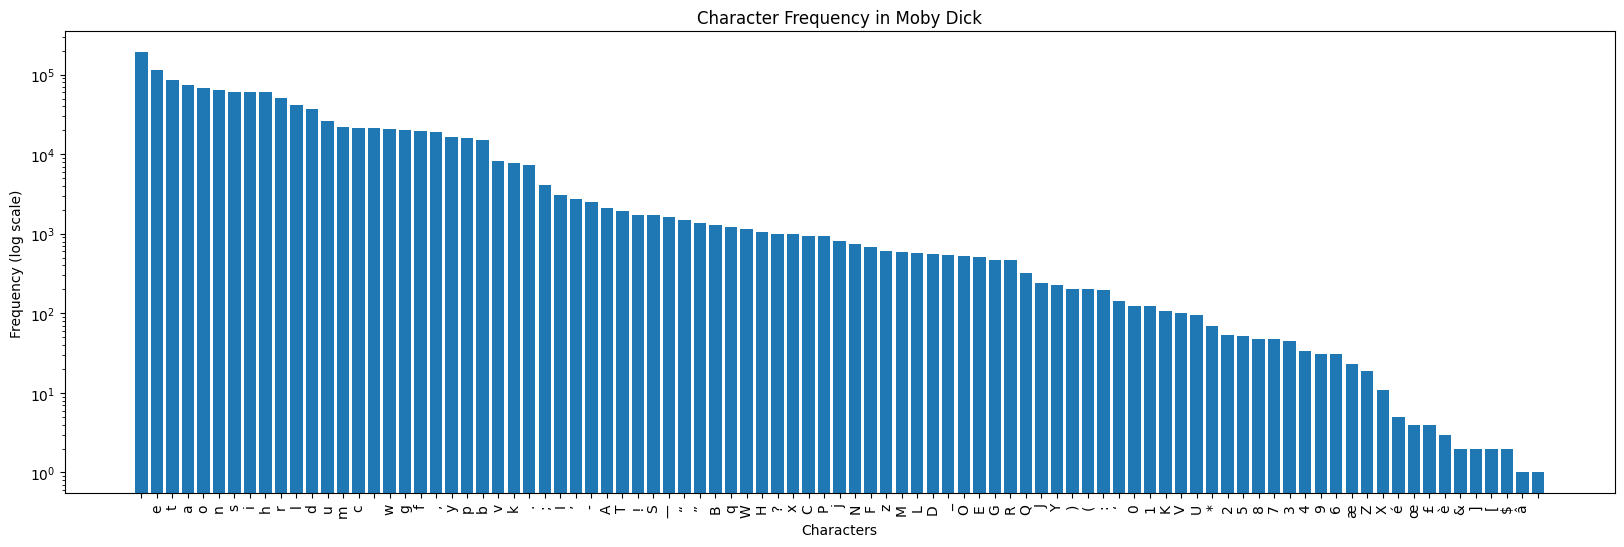

In [3]:
file = "moby_dick.txt"
with open(file, encoding="utf8") as f:
    text = f.read()

characters, frequencies, probabilities = calc_frequencies(file,True)

# Plot the char-frequency pairs as a log histogram
plt.figure(figsize=(20, 6))
plt.bar(characters[::-1], frequencies[::-1], log=True)
plt.xlabel('Characters')
plt.ylabel('Frequency (log scale)')
plt.title('Character Frequency in Moby Dick')
plt.xticks(rotation=90)
# plt.show()

#Construct the Huffman tree and generate the Huffman codes for each character
root_node = build_huffman_tree(characters, frequencies)
huffman_codes = generate_huffman_codes(root_node)

dot = visualize_huffman_tree(root_node)
dot.render("huffman_tree", format="png", cleanup=True)

original_size = os.path.getsize("moby_dick.txt")
compressed_size_char = sum(frequencies[i] * len(huffman_codes[characters[i]]) for i in range(len(characters))) / 8


print(f"Original file size in bits: {original_size}\n\
Compressed file size in bits: {compressed_size_char}\n\
Compression: {(1-compressed_size_char/original_size)*100}%")

### Coding using words as symbols

Original file size in bytes: 1227647
Compressed file size in bytes: 382313.125
Compression: 68.858057324296%


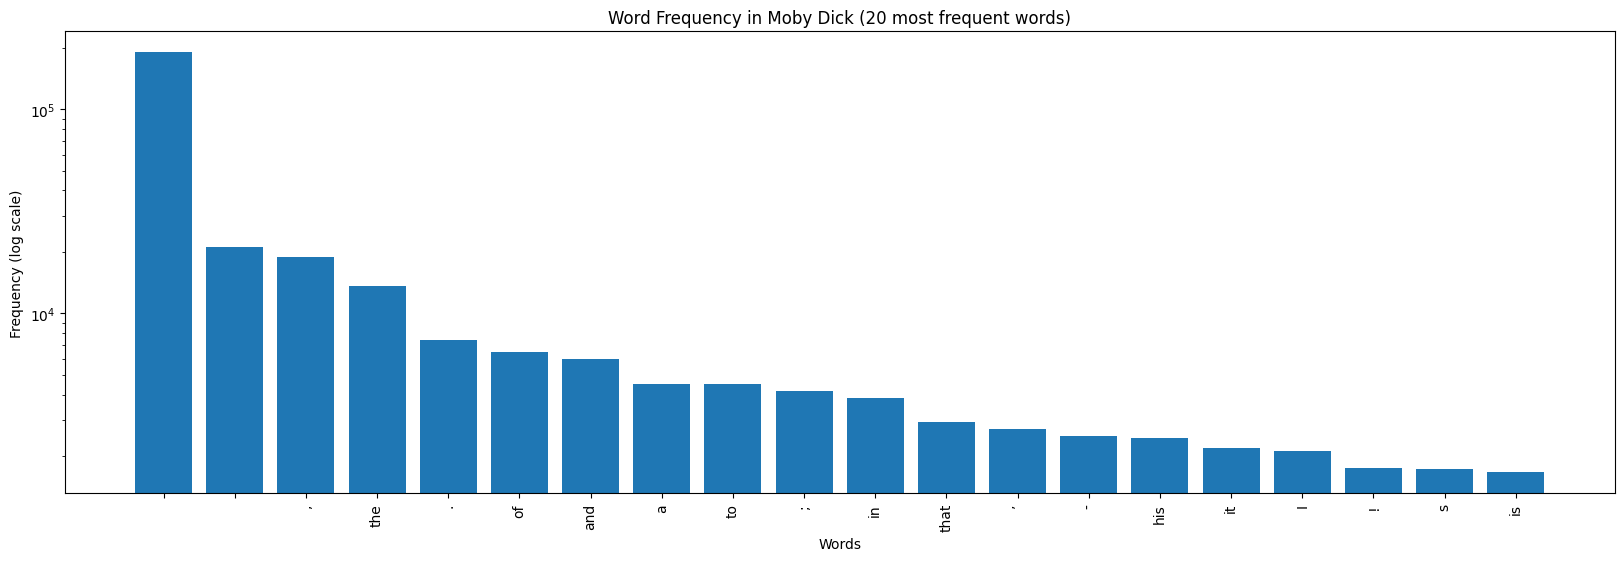

In [4]:
file = "moby_dick.txt"
symbols, frequencies, probabilities = calc_frequencies(file, char_based=False)

# Build the Huffman tree and generate the Huffman codes
root_node = build_huffman_tree(symbols, frequencies)
huffman_codes = generate_huffman_codes(root_node)

compressed_size_word = sum(frequencies[i] * len(huffman_codes[symbols[i]]) for i in range(len(symbols))) / 8

print(f"Original file size in bytes: {original_size}\n\
Compressed file size in bytes: {compressed_size_word}\n\
Compression: {(1-compressed_size_word/original_size)*100}%")

# Plot the word-frequency pairs as a log histogram
plt.figure(figsize=(20, 6))
plt.bar(symbols[-1:-21:-1], frequencies[-1:-21:-1], log=True)
plt.xlabel('Words')
plt.ylabel('Frequency (log scale)')
plt.title('Word Frequency in Moby Dick (20 most frequent words)')
plt.xticks(rotation=90)
plt.show()


### Conclusions on Huffman Coding

Intuitively using a word-based encoding will lead to a larger Huffman tree (too large to show in this case), since there are more unique words in the text than there are unique characters (bounded by letters in the alphabet plus a limited amount of special characters). This means word-based encoding will have long Huffman codes for infrequent words.

However, due to properties of natural language patterns, words like "the", "and", "is" will appear very frequently, and the benefit of encoding these as words rather than individual characters adds up and achieves a better compression rate. This can be explained by the relative probability being higher when using word-based encoding.

The results of using the Huffman Coding algorithm for word- or character-based encoding is showcased below:
* Compression achieved using char-based coding: $45\%$
* Compression achieved using word-based coding: $68\%$
  
A comparison in file size is showcased on the figure below.

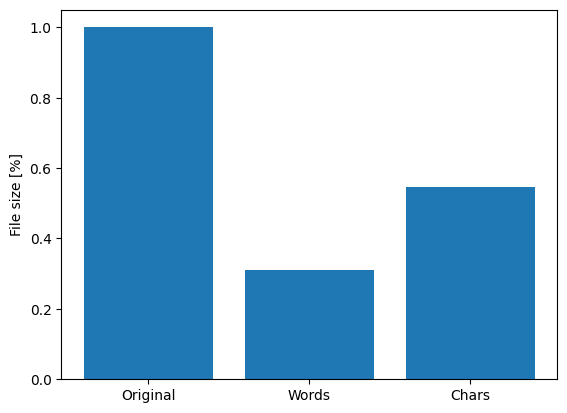

In [5]:
#Compare compression methods words/characters
x_vals = ["Original", "Words", "Chars"]
y_vals = [original_size/original_size,compressed_size_word/original_size,compressed_size_char/original_size]

plt.bar(x_vals,y_vals)
plt.ylabel("File size [%]")
plt.show()

## Shannon-Fano Compression Algorithm

In [ ]:
class Shannon_Fano_node:
    def __init__(self, symbol=None, frequency=None):
        self.symbol: str = symbol
        self.frequency: int = frequency
        self.left: Shannon_Fano_node = None
        self.right: Shannon_Fano_node = None


def calc_frequencies(
    file: str, char_based: bool
) -> tuple[list[str], list[int], list[float]]:
    
    with open(file, encoding="utf8") as f:
        text = f.read()

    if char_based:
        # Count the character frequencies
        char_freq = Counter(text)
        # Sort the character-frequency pairs in ascending order
        sorted_freq = sorted(char_freq.items(), key=lambda item: item[1])
        characters, frequencies = zip(*sorted_freq)
        characters: list[str] = list(characters)
        frequencies: list[str] = list(frequencies)

        probabilities = [freq / sum(frequencies) for freq in frequencies]
        return characters, frequencies, probabilities
    else:
        # Regex pattern: "\w+" one or more words, "[^\w\s]" any character that is not a word or whitespace, "\s" any whitespace character
        pattern = r"\w+|[^\w\s]|\s"
        words = re.findall(pattern, text)
        word_freq = Counter(words)
        # Sort word-frequency pair by frequency
        sorted_freq = sorted(word_freq.items(), key=lambda item: item[1])
        words, frequencies = zip(*sorted_freq)
        words: list[str] = list(words)
        frequencies: list[str] = list(frequencies)

        probabilities: list[float] = [freq / sum(frequencies) for freq in frequencies]
        return words, frequencies, probabilities


def make_nodes(characters: list, frequencies: list) -> list[Shannon_Fano_node]:
    nodes = [
        Shannon_Fano_node(char, freq) for char, freq in zip(characters, frequencies)
    ]
    return sorted(nodes, key=lambda node: node.frequency, reverse=True)


def build_shannon_fano_tree(nodes):
    if len(nodes) == 1:
        return nodes[0]
    
    nodes.sort(key=lambda node: node.frequency, reverse=True)
    total_freq = sum(node.frequency for node in nodes)
    cumulative_freq = 0
    split_index = 0
    
    for i, node in enumerate(nodes):
        cumulative_freq += node.frequency
        if cumulative_freq >= total_freq / 2:
            split_index = i
            break
    
    left_nodes = nodes[:split_index + 1]
    right_nodes = nodes[split_index + 1:]
    
    parent = Shannon_Fano_node()
    parent.left = build_shannon_fano_tree(left_nodes)
    parent.right = build_shannon_fano_tree(right_nodes)
    parent.frequency = total_freq
    
    return parent


def generate_shannon_fano_codes(node, code="", shannon_fano_codes={}):
    if node is not None:
        if node.symbol is not None:
            shannon_fano_codes[node.symbol] = code
        generate_shannon_fano_codes(node.left, code + "0", shannon_fano_codes)
        generate_shannon_fano_codes(node.right, code + "1", shannon_fano_codes)
    return shannon_fano_codes


def visualize_shannon_fano_tree(node):
    def add_edges(graph, node, parent=None, edge_label=""):
        if node is not None:
            node_label = f"{node.symbol}:{node.frequency}" if node.symbol else f"{node.frequency}"
            graph.node(str(id(node)), node_label)
            if parent:
                graph.edge(str(id(parent)), str(id(node)), edge_label)
            add_edges(graph, node.left, node, "0")
            add_edges(graph, node.right, node, "1")

    dot = Digraph()
    add_edges(dot, node)
    return dot




In [ ]:
file = "moby_dick.txt"
characters, frequencies, probabilities = calc_frequencies(file,char_based = True)

nodes = make_nodes(characters, frequencies)
root_node = build_shannon_fano_tree(nodes)
shannon_fano_codes = generate_shannon_fano_codes(root_node)

# Visualize the Shannon-Fano tree
dot = visualize_shannon_fano_tree(root_node)
dot.render("shannon_fano_tree", format="png", cleanup=True)

print(len(shannon_fano_codes))


18675


In [ ]:
file = "moby_dick.txt"
words, frequencies, probabilities = calc_frequencies(file, char_based=False)

nodes = make_nodes(words, frequencies)

root_node = build_shannon_fano_tree(nodes)
shannon_fano_codes = generate_shannon_fano_codes(root_node)

compressed_size_bytes = sum(frequencies[i] * len(shannon_fano_codes[characters[i]]) for i in range(len(characters)))/8

compressed_size_bytes


18675


- Implement a version of LZW or LZ77 and encode the book. Your report should provide both the code listing for the compression algorithms and a short discussion of the results you obtained